In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

from imblearn.pipeline import Pipeline 
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [2]:
aisles = pd.read_csv('./data/aisles.csv')
departments = pd.read_csv('./data/departments.csv')
order_products_prior = pd.read_csv('./data/order_products_prior.csv')
order_products_train = pd.read_csv('./data/order_products_train.csv')
orders = pd.read_csv('./data/orders.csv')
products = pd.read_csv('./data/products.csv')

In [3]:
# look at the shape of all data
print(aisles.shape)
print(departments.shape)
print(order_products_prior.shape)
print(order_products_train.shape)
print(orders.shape)
print(products.shape)

(134, 2)
(21, 2)
(793924, 4)
(53704, 4)
(82683, 7)
(49688, 4)


In [4]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1
2,12,43772,3,1
3,12,37886,4,1
4,12,37215,5,0


In [7]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1
3,1077,21137,4,1
4,1119,6046,1,1


In [8]:
# order_products_prior.product_id.isin(order_products_train.product_id).value_counts()

In [9]:
# orders[orders.eval_set=='prior'].groupby(['user_id','product_id'])['order_id'].count().sort_values(ascending=False)
# 只留下user-product pair预测是否复购

In [10]:
# prior_details = order_products_prior.merge(orders, on = 'order_id')
# prior_details.groupby(['user_id','product_id'])['order_id'].count().sort_values(ascending=False)
# 过去买过几次先忽略，直接为user-product_id pair标注未来是否复购。
# 这里还没到构建feature阶段，只是在为每一个pair构建标签；
# 未来构建feature也是按照user-product pair为其构建的，也是一个pair对应一组feature,其中会有一些aggregation feature

In [11]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [12]:
# orders.sort_values(by=['user_id','days_since_prior_order'])

In [13]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


# 1. Data Exploration
## 1.1 Build order history table

In [14]:
# Build prior order details table for data exploration
prior_order_details = order_products_prior.merge(orders, on ='order_id')

In [15]:
# convert day of week to string for visualization
prior_order_details['order_dow']=prior_order_details['order_dow'].apply(lambda x:'Sunday' if x==0 else x)
prior_order_details['order_dow']=prior_order_details['order_dow'].apply(lambda x:'Monday' if x==1 else x)
prior_order_details['order_dow']=prior_order_details['order_dow'].apply(lambda x:'Tuesday' if x==2 else x)
prior_order_details['order_dow']=prior_order_details['order_dow'].apply(lambda x:'Wednesday' if x==3 else x)
prior_order_details['order_dow']=prior_order_details['order_dow'].apply(lambda x:'Thursday' if x==4 else x)
prior_order_details['order_dow']=prior_order_details['order_dow'].apply(lambda x:'Friday' if x==5 else x)
prior_order_details['order_dow']=prior_order_details['order_dow'].apply(lambda x:'Saturday' if x==6 else x)

In [16]:
prior_order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,Saturday,8,10.0
1,12,15221,2,1,152610,prior,22,Saturday,8,10.0
2,12,43772,3,1,152610,prior,22,Saturday,8,10.0
3,12,37886,4,1,152610,prior,22,Saturday,8,10.0
4,12,37215,5,0,152610,prior,22,Saturday,8,10.0


## 1.2 Visualize order frequency on DoW

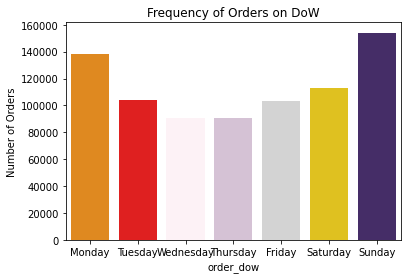

In [17]:
ax = sns.countplot(palette=["#FF8C00","#FF0000", "#FFF0F5","#D8BFD8","#D3D3D3","#FFD700","#432371"],x='order_dow',data=prior_order_details,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Frequency of Orders on DoW')
plt.ylabel('Number of Orders')
plt.show()

**Conclusion**: People buy things mostly on Sunday.

## 2.3 Visualize order frequency on HoD

In [18]:
# involves quality check: in case their are multiple HoD in the same order
order_hours_counts = orders.groupby('order_id')['order_hour_of_day'].mean().reset_index()
order_hours_counts

,order_id,order_hour_of_day
0,12,8
1,50,13
2,90,16
3,236,12
4,252,18
...,...,...
82678,3420895,19
82679,3420966,10
82680,3420996,9
82681,3421018,9


> The number of rows is the same with the number of rows of orders table

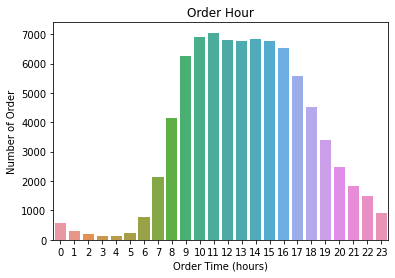

In [19]:
# order_hod_stats = order_hours_counts['order_hour_of_day']
sns.countplot(x='order_hour_of_day',data=order_hours_counts)
plt.title("Order Hour")
plt.ylabel("Number of Order")
plt.xlabel('Order Time (hours)')
plt.show()

**Conclusions**: Most frequent order time is from 8 a.m. to 6 p.m.

## 1.4 Reorder Pattern Analysis (upon time)

Text(0.5, 33.0, 'Hours')

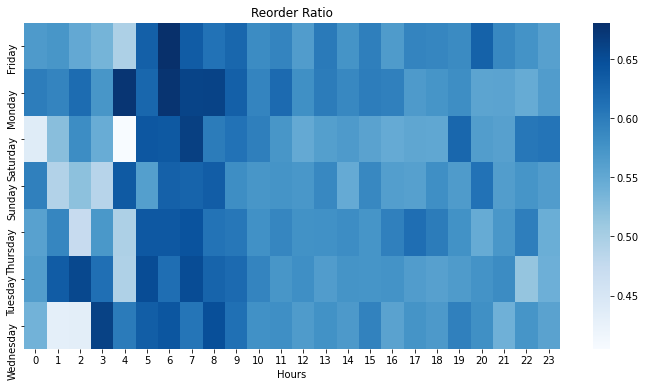

In [20]:
reorder_table = prior_order_details.groupby(["order_dow", "order_hour_of_day"])["reordered"].mean().reset_index()
reorder_heatmap = reorder_table.pivot('order_dow','order_hour_of_day','reordered')
plt.figure(figsize=(12,6))
sns.heatmap(reorder_heatmap,cmap='Blues')
plt.title('Reorder Ratio')
plt.ylabel('')
plt.xlabel('Hours')

**Conclusions**: Products bought during weekdays and early hours of a day are more likely to be reordered.

## 1.5 The top 3 popular products

In [21]:
prior_products_details = order_products_prior.merge(products, on ='product_id')
prior_products_details.groupby('product_name')['product_id'].count().sort_values(ascending=False).head(3)

product_name
Banana                    10951
Bag of Organic Bananas     9424
Organic Baby Spinach       6028
Name: product_id, dtype: int64

**Conclusion**: The three most popular products are: Banana, Bag of Organic Bananas, Organic Baby Spinach.

## 1.6 The top 3 popular aisles

In [22]:
prior_aisles_details = prior_products_details.merge(aisles,on='aisle_id')
prior_aisles_details.groupby('aisle')['aisle_id'].count().sort_values(ascending=False).head(3)

aisle
fresh fruits                  86351
fresh vegetables              85062
packaged vegetables fruits    43436
Name: aisle_id, dtype: int64

**Conclusion**: The three most popular aisles are: fresh fruits, fresh vegetables, packaged vegetables fruits.

## 1.7 The top 3 popular departments

In [23]:
prior_departments_details = prior_products_details.merge(departments,on='department_id')
prior_departments_details.groupby('department')['department_id'].count().sort_values(ascending=False).head(3)

department
produce       231189
dairy eggs    129910
snacks         71685
Name: department_id, dtype: int64

**Conclusion**: The three most popular departments are: produce, dairy eggs and snacks.

# 2. Data Quality Check
## 2.1 Validate the days_since_prior_order column in orders

In [24]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [25]:
# NaN count in ['days_since_prior_order'] column
orders[orders['days_since_prior_order'].isnull()==True]['order_id'].count()

5000

In [26]:
# order_number ==1 count
orders[orders['order_number']==1]['order_id'].count()

5000

In [27]:
# user_id count
orders.groupby('user_id').count().shape[0]

5000

**Conclusion**: From the above analysis, we can conclude that the number of first bought products and order number are aligned, and are the same as the number of users.

## 2.2.Validate Valid orders matching in the prior table

In [28]:
orders.groupby(['eval_set'], as_index=False).agg(OrderedDict([('order_id','nunique')]))
# .agg(): diy different aggregation functions for different columns
# OrderedDict: diy the order of data and how they are presented

,eval_set,order_id
0,prior,77683
1,train,5000


In [29]:
# check the number of order_id in prior table 
order_products_prior['order_id'].nunique()

77683

In [30]:
# check the overlap between tables
order_products_prior[order_products_prior['order_id'].isin(orders[orders.eval_set=='prior']['order_id'])].order_id.nunique()

77683

**Conclusion**: There are no difference regarding the prior order_id and its numbers between two tables.

## 2.3. Validate orders matching in the train table

In [31]:
# check the number of order_id in prior table 
order_products_train['order_id'].nunique()

5000

In [32]:
# check the overlap between tables
order_products_train[order_products_train['order_id'].isin(orders[orders.eval_set=='train']['order_id'])].order_id.nunique()

5000

**Conclusion**: There are no difference regarding the train order_id and its numbers between two tables.

## 2.4. Validate the order intersection between prior and train table

In [33]:
order_products_train.order_id.isin(order_products_prior.order_id).value_counts()

False    53704
Name: order_id, dtype: int64

**Conclusion**: There are no intersection of orders between prior and train table.

## 2.5. Validate the user_id matching in prior and train set

In [34]:
orders.groupby(['eval_set'], as_index=False).agg(OrderedDict([('user_id','nunique')]))

,eval_set,user_id
0,prior,5000
1,train,5000


In [35]:
set(orders[orders.eval_set=='prior']['user_id'])==set(orders[orders.eval_set=='train']['user_id'])

True

**Conclusion**: All the users are the same between prior and train table.The number of unique users are 5000.

## 2.6. Validate order counts in the train dataset

In [36]:
orders[orders.eval_set == 'train'].groupby('user_id').agg(OrderedDict([('order_number','count')])).sort_values(by=['order_number'],ascending=False)

,order_number
user_id,
50,1
135574,1
135956,1
135881,1
135743,1
...,...
67698,1
67691,1
67660,1


**Conclusion**: We can see that EACH user only have ONE order in training data.

## 2.7. Validate the relative order of order_num in prior and train dataset

In [37]:
df_prior_order_max = orders[orders.eval_set == 'prior'].groupby('user_id').agg(OrderedDict([('order_number','max')]))

In [38]:
df_train_order_min = orders[orders.eval_set == 'train'].groupby('user_id').agg(OrderedDict([('order_number','min')]))

In [39]:
user_order_num = pd.merge(df_prior_order_max,df_train_order_min,on=['user_id'])
user_order_num['diff']=user_order_num['order_number_x']-user_order_num['order_number_y']
user_order_num['diff'].value_counts()

-1    5000
Name: diff, dtype: int64

**Conclusion**:The order_number in prior data are all smaller than the number from training data for the same user.

# 3. Construct Model Label

标签是已经复购，预测是未来复购，因此标签也应从未来得到，而不是从过去得到。因此eval_set = train 的部分不能被纳入training，因为我们不知道这些产品未来是否被再次购买。而prior里的产品可以知道未来是否被再次购买，因为有train的信息，而train发生在prior 之后。reordered标记为0的意味着之前没有买过，但它可能在train表里被购买。也算有复购，因此不能直接用reordered这一列作为label。

In [40]:
train_details = order_products_train.merge(orders, on = 'order_id')
prior_details = order_products_prior.merge(orders, on = 'order_id')
train_unique_key = train_details['user_id'].astype('str') + '_' + train_details['product_id'].astype('str')

In [41]:
model_all_data = prior_details[['user_id','product_id','order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']] # ]] #为什么要后面这几列？
# 由于同一个user在不同order里可能有相同的产品，因此需要去重
model_all_data = model_all_data.drop_duplicates(subset=['user_id', 'product_id'])
model_all_data['unique_key'] = model_all_data['user_id'].astype('str') + '_' + model_all_data['product_id'].astype('str')
model_all_data['label'] = 0
model_all_data.loc[model_all_data['unique_key'].isin(train_unique_key),'label'] = 1

In [42]:
model_all_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label
0,152610,30597,22,6,8,10.0,152610_30597,0
1,152610,15221,22,6,8,10.0,152610_15221,0
2,152610,43772,22,6,8,10.0,152610_43772,0
3,152610,37886,22,6,8,10.0,152610_37886,0
4,152610,37215,22,6,8,10.0,152610_37215,0


# 4. Construct Model features
## 4.1 Feature Group 1: user-product activity features

In [43]:
user_product_features = ['user_product__total_orders'
                         ,'user_product__add_to_cart_order_mean'
                         ,'user_product__reordered_mean'
                         ,'user_product__most_dow'
                         ,'user_product__most_hod']

In [44]:
df_user_product_features = (prior_details.groupby(['product_id','user_id'],as_index=False).agg(OrderedDict(
                                [('order_id','count'), # order frequency
                                 ('add_to_cart_order','mean'), # the order of adding to cart
                                 ('reordered','mean'), # the reorder rate of the product for a certain user
                                 ('order_dow',(lambda x: x.mode()[0])), # most frequent purchase day of week
                                 ('order_hour_of_day',(lambda x: x.mode()[0])), # most frequent purchase hour of day
                                ])))

In [45]:
df_user_product_features.columns=['product_id','user_id'] + user_product_features
model_all_data = model_all_data.merge(df_user_product_features, on = ['user_id', 'product_id'])
model_all_data

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__most_dow,user_product__most_hod
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.00,0.800,6,13
1,152610,15221,22,6,8,10.0,152610_15221,0,8,8.25,0.875,4,9
2,152610,43772,22,6,8,10.0,152610_43772,0,2,3.00,0.500,5,8
3,152610,37886,22,6,8,10.0,152610_37886,0,2,3.50,0.500,6,8
4,152610,37215,22,6,8,10.0,152610_37215,0,1,5.00,0.000,6,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
329801,189570,315,9,0,9,9.0,189570_315,0,1,11.00,0.000,0,9
329802,189570,42828,9,0,9,9.0,189570_42828,0,1,15.00,0.000,0,9
329803,189570,46666,9,0,9,9.0,189570_46666,0,1,16.00,0.000,0,9
329804,186579,29418,26,6,17,21.0,186579_29418,0,1,7.00,0.000,6,17


## 4.2 Feature Group 2: product features

In [46]:
# type 1: due to users' behavior;
product_features = [
    'product__total_orders',
    'product__add_to_cart_order_mean',
    'product__total_users',
    'product__reordered_mean',
    'product__most_dow',
    'product__most_hod',
    'product__days_since_prior_order_mean'
]

In [47]:
df_product_features = (prior_details.groupby(['product_id'],as_index=False)
                       .agg(OrderedDict([
                           ('order_id','nunique'), # purchases time by all users
                           ('add_to_cart_order','mean'), # average order of the product being added to the cart
                           ('user_id','nunique'), # purchased user
                           ('reordered','mean'), # average reorder rate
                           ('order_dow',(lambda x: x.mode()[0])), # most frequent day of week
                           ('order_hour_of_day',(lambda x: x.mode()[0])), # most frequent hour of day
                           ('days_since_prior_order','mean') # mean of the date that a product being purchased since prior order
                       ])))
df_product_features.columns = ['product_id'] + product_features
model_all_data = model_all_data.merge(df_product_features, on = ['product_id'])

In [48]:
# type 2: due to product itself
model_all_data = model_all_data.merge(products[['product_id','aisle_id', 'department_id']], on = ['product_id'])

In [49]:
model_all_data.rename(columns={'aisle_id':'product__aisle_id','department_id':'product__department_id'},inplace=True)
model_all_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label,user_product__total_orders,user_product__add_to_cart_order_mean,...,user_product__most_hod,product__total_orders,product__add_to_cart_order_mean,product__total_users,product__reordered_mean,product__most_dow,product__most_hod,product__days_since_prior_order_mean,product__aisle_id,product__department_id
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.000000,...,13,85,4.2,23,0.729412,3,9,12.592593,53,16
1,112604,30597,15,3,10,1.0,112604_30597,0,5,3.800000,...,10,85,4.2,23,0.729412,3,9,12.592593,53,16
2,75304,30597,28,2,8,12.0,75304_30597,0,2,29.000000,...,8,85,4.2,23,0.729412,3,9,12.592593,53,16
3,22499,30597,20,4,9,30.0,22499_30597,1,18,2.722222,...,9,85,4.2,23,0.729412,3,9,12.592593,53,16
4,190626,30597,11,1,9,14.0,190626_30597,0,9,2.111111,...,9,85,4.2,23,0.729412,3,9,12.592593,53,16


## 4.3 Feature Group 3: user features

In [50]:
user_features = [
    'user__order_count',
    'user__product_count',
    'user__days_since_prior_order_mean',
    'user__reordered_mean',
    'user__most_dow',
    'user__most_hod',
]

In [51]:
df_user_features = (prior_details.groupby(['user_id'],as_index=False)
                   .agg(OrderedDict([
                       ('order_id','nunique'), # the number of orders placed per user
                       ('product_id','count'), # the number of products purchased per user
                       ('days_since_prior_order','mean'), # the average time between orders per user
                       ('reordered','mean'), # the total reorder rate per user
                       ('order_dow',(lambda x: x.mode()[0])), # most frequent purchase date of a week
                       ('order_hour_of_day',(lambda x: x.mode()[0])), # most frequent purchase time of a day
                   ])))
df_user_features.columns=['user_id'] + user_features

In [52]:
model_all_data = model_all_data.merge(df_user_features, on = ['user_id'])

In [53]:
print('Labels number of the training data:\n',model_all_data['label'].value_counts())
print('Shape of the training data:',model_all_data.shape)

Labels number of the training data:
 0    297467
1     32339
Name: label, dtype: int64
Shape of the training data: (329806, 28)


# 5. Feature Data Analysis & Tranformation

In [55]:
# reorder features and label
unique_key = ['user_id', 'product_id']
raw_features = ['user_product__total_orders',
                'user_product__add_to_cart_order_mean',
                'user_product__reordered_mean',
                'user_product__most_dow',
                'user_product__most_hod',
                'product__total_orders',
                'product__add_to_cart_order_mean',
                'product__total_users',
                'product__reordered_mean',
                'product__most_dow',
                'product__most_hod',
                'product__days_since_prior_order_mean',
                'user__order_count',
                'user__product_count',
                'user__days_since_prior_order_mean',
                'user__reordered_mean',
                'user__most_dow',
                'user__most_hod',
                'product__aisle_id',
                'product__department_id',
               ]
label = ['label']

In [56]:
model_all_data = model_all_data[unique_key + raw_features + label]
model_all_data.head()

,user_id,product_id,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__most_dow,user_product__most_hod,product__total_orders,product__add_to_cart_order_mean,product__total_users,...,product__days_since_prior_order_mean,user__order_count,user__product_count,user__days_since_prior_order_mean,user__reordered_mean,user__most_dow,user__most_hod,product__aisle_id,product__department_id,label
0,152610,30597,5,2.00,0.800,6,13,85,4.200000,23,...,12.592593,26,408,10.953804,0.375,6,12,53,16,0
1,152610,15221,8,8.25,0.875,4,9,30,7.033333,10,...,13.653846,26,408,10.953804,0.375,6,12,84,16,0
2,152610,43772,2,3.00,0.500,5,8,508,9.096457,171,...,12.008565,26,408,10.953804,0.375,6,12,83,4,0
3,152610,37886,2,3.50,0.500,6,8,49,11.204082,28,...,11.489362,26,408,10.953804,0.375,6,12,53,16,0
4,152610,37215,1,5.00,0.000,6,8,165,8.278788,61,...,11.490066,26,408,10.953804,0.375,6,12,98,7,0


## 5.1 Label Ratio

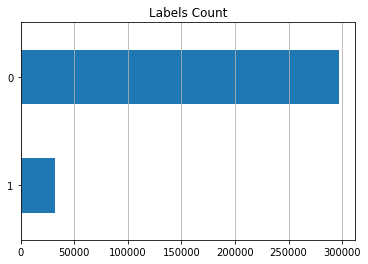

In [58]:
label_count = model_all_data['label'].value_counts()
ax = label_count.sort_values().plot(kind='barh',title='Labels Count')
ax.grid(axis='x')

## 2.2 Null value check

In [60]:
model_all_data.isna().sum()

user_id                                   0
product_id                                0
user_product__total_orders                0
user_product__add_to_cart_order_mean      0
user_product__reordered_mean              0
user_product__most_dow                    0
user_product__most_hod                    0
product__total_orders                     0
product__add_to_cart_order_mean           0
product__total_users                      0
product__reordered_mean                   0
product__most_dow                         0
product__most_hod                         0
product__days_since_prior_order_mean    726
user__order_count                         0
user__product_count                       0
user__days_since_prior_order_mean         0
user__reordered_mean                      0
user__most_dow                            0
user__most_hod                            0
product__aisle_id                         0
product__department_id                    0
label                           

## 2.3 Categorical Feature Transformation

In [62]:
# one-hot encoding for product__department_id
model_all_data = pd.concat(
    [model_all_data.drop('product__department_id',axis=1),
     pd.get_dummies(model_all_data['product__department_id'],
                    prefix='product__department_id_')],
    axis = 1)

# 6. Split Dataset to Train, Validation and Test

In [63]:
# split all the data regarding user id, but not directly split all the data, as the prediction is conducted per user level
test_user_ids = model_all_data.user_id.drop_duplicates().sample(frac=0.2)
train_data = model_all_data[~model_all_data.user_id.isin(test_user_ids)]
test_data = model_all_data[model_all_data.user_id.isin(test_user_ids)]

In [64]:
print('The shape of the whole dataset is',model_all_data.shape)
print('The shape of training data is',train_data.shape)
print('The shape of testing data is',test_data.shape)

The shape of the whole dataset is (329806, 43)
The shape of training data is (262421, 43)
The shape of testing data is (67385, 43)


# 7. Model Selection with Cross Validation

## 7.1 Model Selection with All features

In [65]:
train_x = train_data.drop(['user_id','product_id','label'],axis=1)
train_y = train_data['label']

In [66]:
classifier = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

In [ ]:
# feature engineering should be conducted along with cross validation


## 7.2 Feature Selection

# 8. Hyper-parameter Tuning for GradientBoosting Classifier

# 9. Train the Final Classifier

# 10. Evaluate Model on Test Data